In [1]:
import cobra
import pandas as pd 
import os
from os.path import join
from cobra import Model, Reaction, Metabolite
from cobra.sampling import sampling
import numpy as np
os.environ["R_HOME"] = f"{os.environ['CONDA_PREFIX']}\\Lib\\R"
import rpy2.robjects 
from plotnine import *
import matplotlib.pyplot as plt

In [3]:
# Importing the model
model1=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\Rt_IFO0880_jsb.xml")
model1.objective = "BIOMASS_RT"  

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-21


In [4]:
# Lab data
glucose_uptakes= [0.476, 1.114, 1.648, 2.305, 3.1] # the fifth glc uptake value was calculated

# All fluxes for getting all rxn names
solution1 = model1.optimize()
all_fluxes = solution1.fluxes.to_frame(name='Flux')

In [5]:
# Get all fluxes on different glucose uptake
all_fluxes_biomass_max = pd.DataFrame(columns=['Growth rate', 'Glucose uptake', *all_fluxes.index], index=range(len(glucose_uptakes))) #flux_values.index gives the row names column, * extracts the list of strings

for i in range(len(glucose_uptakes)):
    model=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\Rt_IFO0880_jsb.xml")
    model.objective = "BIOMASS_RT"  
    model.reactions.EX_glc__D_e.bounds = -(glucose_uptakes[i]), -(glucose_uptakes[i])
    
    solution = model.optimize()
    all_fluxes_biomass_max.loc[i] = solution.fluxes[['BIOMASS_RT', 'EX_glc__D_e', *all_fluxes.index]].values

all_fluxes_biomass_max

,Growth rate,Glucose uptake,ALCD25yi,MTHFCm,AMPN,DAGCPTer_RT,PYRt2,NNDPRm,HMGCOASm,PDE4,...,BTNt2i,EX_fol_e,FOLt,NADtm,EX_pydxn_e,PYDXNtr,RIBFLVt2,tr_0001,EXC_OUT_phyto_d,MDHc
0,0.033961,-0.476,0.0,0.0,0.0,0.0,0.0,0.0,-0.00006,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.198513
1,0.082468,-1.114,0.0,0.0,0.0,0.0,0.0,0.0,-0.000145,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.482057
2,0.123068,-1.648,0.0,0.0,0.0,0.0,0.0,0.0,-0.000217,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.719381
3,0.17302,-2.305,0.0,0.0,0.0,0.0,0.0,0.0,-0.000305,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.011369
4,0.233464,-3.1,0.0,0.0,0.0,0.0,0.0,0.0,-0.000412,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.364688


In [6]:
# Get specific metabolites with their fluxes
exchange_fluxes_table = all_fluxes_biomass_max[['EX_glc__D_e', 'EX_o2_e', 'EX_nh4_e','EX_so4_e','EX_pi_e', 'EX_co2_e']]

for i in range(len(exchange_fluxes_table.columns)):
    exchange_fluxes_table = exchange_fluxes_table.rename(columns = {exchange_fluxes_table.columns[i]: getattr(model.reactions, exchange_fluxes_table.columns[i]).name})

exchange_fluxes_table

,D-Glucose exchange,O2 exchange,Ammonia exchange,Sulfate exchange,Phosphate exchange,CO2 exchange
0,-0.476,-1.137428,-0.224151,-0.003404,-0.009041,1.264728
1,-1.114,-2.510728,-0.544314,-0.008266,-0.021954,2.819853
2,-1.648,-3.660167,-0.812287,-0.012336,-0.032763,4.121479
3,-2.305,-5.074364,-1.141985,-0.017343,-0.046061,5.722917
4,-3.1,-6.785607,-1.540934,-0.023402,-0.062152,7.660731


In [7]:
intracellular_fluxes = all_fluxes_biomass_max[['ATPM', 'EX_glc__D_e', 'G6PDH2r', 'TKT1', 'TALA','TKT2', 'XPK', 'FBA', 'PYRDC','PDHm', 'ACITL']] #'MDHm'

for i in range(len(intracellular_fluxes.columns)):
    if intracellular_fluxes.columns[i] != 'TKT1' and intracellular_fluxes.columns[i] != 'TKT2':
        intracellular_fluxes = intracellular_fluxes.rename(columns = {intracellular_fluxes.columns[i]: getattr(model.reactions, intracellular_fluxes.columns[i]).name})

# Adding XPK and FPK together
intracellular_fluxes['Xylulose-5-phosphate phosphoketolase'] = intracellular_fluxes['Xylulose-5-phosphate phosphoketolase'] + all_fluxes_biomass_max['FPK']

# Change G6PDH2rp column name to oxpp 
intracellular_fluxes = intracellular_fluxes.rename(columns = {'G6PDH2r': 'oxPPP', 'ATP maintenance requirement': 'NGAM', 'Xylulose-5-phosphate phosphoketolase': 'Phosphoketolase', 
                                                              'TKT1': 'Transketolase 1', 'TKT2': 'Transketolase 2'})
intracellular_fluxes

,NGAM,D-Glucose exchange,Glucose 6-phosphate dehydrogenase,Transketolase 1,Transaldolase,Transketolase 2,Phosphoketolase,Fructose-bisphosphate aldolase,Pyruvate decarboxylase,Pyruvate dehydrogenase,ATP-Citrate lyase
0,1.22,-0.476,0.013915,-0.011487,-0.011487,-0.017843,0.0,0.346383,0.03121,0.53422,0.182372
1,1.22,-1.114,0.084058,-0.011138,-0.793629,-0.026574,0.0,0.0,0.075789,1.196733,0.442861
2,1.22,-1.648,0.142767,-0.010847,-1.158355,-0.033882,0.0,0.0,0.113101,1.751251,0.660888
3,1.22,-2.305,0.214998,-0.010488,-1.607091,-0.042872,0.0,0.0,0.159007,2.433495,0.929135
4,1.22,-3.1,0.302401,-0.010054,-2.150083,-0.053752,0.0,0.0,0.214556,3.25904,1.253725


Text(0, 0.5, 'Flux')

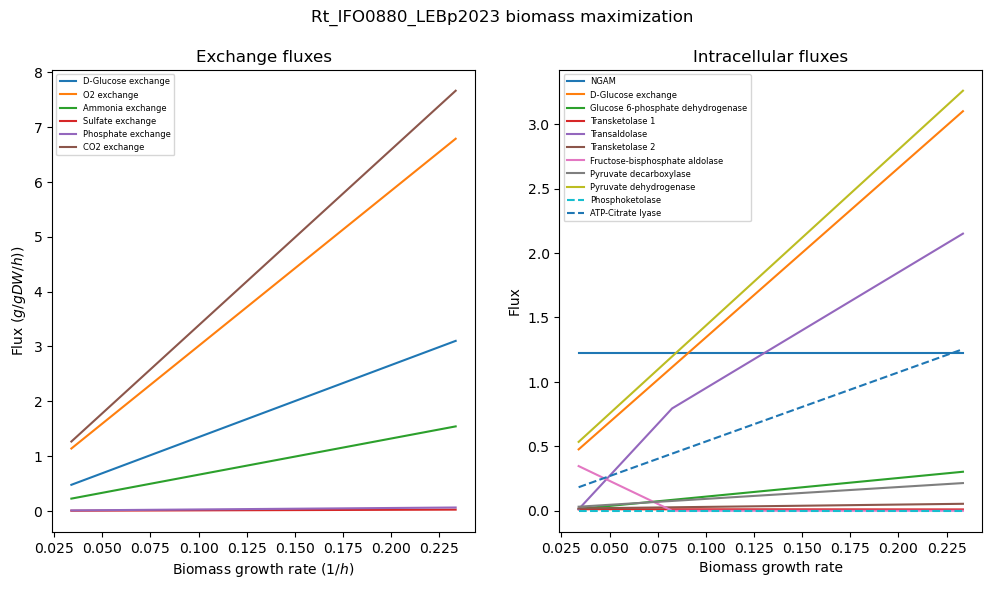

In [12]:
# Plot exchange and intracellular fluxes
fig, ax = plt.subplots(1, 2, figsize=(12,6)) #, 
fig.suptitle('Rt_IFO0880_LEBp2023 biomass maximization')

# Sample data

x1 = all_fluxes_biomass_max['BIOMASS_RT']
y1 = np.abs(exchange_fluxes_table)

ax[0].plot(x1, y1, '-', label= y1.columns) #
ax[0].legend(fontsize=6, loc='upper left')
ax[0].set_title("Exchange fluxes") #fluxes biomass maximization
ax[0].set_xlabel('Biomass growth rate $(1/h)$')
ax[0].set_ylabel('Flux $(g/gDW/h)$')

x2 = all_fluxes_biomass_max['BIOMASS_RT']
y2 = np.abs(intracellular_fluxes.drop(columns = ['Phosphoketolase','ATP-Citrate lyase']))
y3 = np.abs(intracellular_fluxes[['Phosphoketolase','ATP-Citrate lyase']])

ax[1].plot(x2, y2, '-', label= y2.columns) #
ax[1].plot(x2, y3, '--', label= y3.columns) # ACL and phosphoketolase

ax[1].legend(fontsize=6, loc='upper left')
ax[1].set_title("Intracellular fluxes")
ax[1].set_xlabel('Biomass growth rate $(1/h)$')
ax[1].set_ylabel('Flux $(g/gDW/h)$')

Cofactor balances

In [2]:
glucose_uptakes= [0.476, 1.114, 1.648, 2.305, 3.1] # 
# Cofactor lists
nadphs = ['nadph_c', 'nadph_m', 'nadph_x']
nadhs = ['nadh_c', 'nadh_m', 'nadh_x', 'nadh_r']
atps = ['atp_c', 'atp_m', 'atp_v', 'atp_n', 'atp_r'] 

# Make a function for getting cofactor fluxes (all reactions where given metabolite is and their fluxes)

def cofactor_all_rxn_fluxes(cofactor_list, i):
    producing_fluxes = pd.DataFrame() 
    consuming_fluxes = pd.DataFrame()

    model=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\Rt_IFO0880_jsb.xml")
    model.objective = "BIOMASS_RT"  
    model.reactions.EX_glc__D_e.bounds = -(glucose_uptakes[i]), -(glucose_uptakes[i])    
    solution = model.optimize()
        
    for metabolite in cofactor_list:
        producing_fluxes = pd.concat([producing_fluxes, getattr(model.metabolites, metabolite).summary().producing_flux])
        consuming_fluxes = pd.concat([consuming_fluxes, getattr(model.metabolites, metabolite).summary().consuming_flux])
    
    for reaction in producing_fluxes.index:
        if reaction in consuming_fluxes.index and abs(round(producing_fluxes.loc[reaction, 'flux'], 3)) == abs(round(consuming_fluxes.loc[reaction, 'flux'], 3)):
            producing_fluxes = producing_fluxes.drop([reaction])
            consuming_fluxes = consuming_fluxes.drop([reaction])
            
    cofactor_fluxes = pd.concat([producing_fluxes, consuming_fluxes])

    cofactor_fluxes = cofactor_fluxes.sort_values(by='flux', ascending=False).drop(columns = ['percent']) # drop percent column, bc these percents are not for nadph sum (the percent is for specific compartment)
    cofactor_fluxes = cofactor_fluxes[(cofactor_fluxes['flux']) != 0.0] # for getting non-zero fluxes only

    cofactor_sum_producing_flux = sum(cofactor_fluxes[cofactor_fluxes['flux'] > 0]['flux']) # for getting the sum of producing fluxes
    cofactor_sum_consuming_flux = sum(cofactor_fluxes[cofactor_fluxes['flux'] < 0]['flux']) # for getting the sum of consumed fluxes
    print(f'SUM produced: {cofactor_sum_producing_flux}, SUM consumed: {cofactor_sum_consuming_flux}')

    if round(cofactor_sum_producing_flux, 3) == round(abs(cofactor_sum_consuming_flux), 3):
        cofactor_fluxes['percent'] = abs(cofactor_fluxes['flux']/cofactor_sum_producing_flux) # add percent column

    return cofactor_fluxes

# Making a pie chart
def cofactor_fluxes_pie_chart(cofactor_fluxes,  title): 
    threshold = 0.05 # threshold shows the percent of the flux for including in others sector on pie chart 
    # The three lines below are for grouping together reactions with low fluxes in producing
    producing_cofactor_fluxes_draw = cofactor_fluxes[(cofactor_fluxes['flux'] > 0).copy()]    
    producing_cofactor_fluxes_draw.loc[producing_cofactor_fluxes_draw['percent'] < threshold, 'reaction'] = 'Other producing'
    producing_cofactor_fluxes_draw = producing_cofactor_fluxes_draw.groupby('reaction')[['percent', 'flux']].sum()        
    
    # The three lines below are for grouping together reactions with low fluxes in consuming 
    consuming_cofactor_fluxes_draw = cofactor_fluxes[(cofactor_fluxes['flux'] < 0).copy()]
    consuming_cofactor_fluxes_draw.loc[consuming_cofactor_fluxes_draw['percent'] < threshold, 'reaction'] = 'Other consuming'
    consuming_cofactor_fluxes_draw = consuming_cofactor_fluxes_draw.groupby('reaction')[['percent', 'flux']].sum()
    
    # y_producing = producing_cofactor_fluxes_draw['percent']
    # labels_producing = producing_cofactor_fluxes_draw[['reaction', 'flux']] 
    
    # y_consuming = abs(consuming_cofactor_fluxes_draw['percent'])
    # labels_consuming = consuming_cofactor_fluxes_draw[['reaction', 'flux']]
    
    producing_and_consuming_fluxes = pd.concat([producing_cofactor_fluxes_draw, consuming_cofactor_fluxes_draw])
    
    # reaction_IDs = pd.concat([labels_producing, labels_consuming])
    
    model = cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\Rt_IFO0880_jsb.xml")
    model.objective = "BIOMASS_RT" 
    solution = model.optimize()   
    
    reaction_names_w_flux = []
    for reaction in producing_and_consuming_fluxes.index:
        if reaction != 'Other producing' and reaction != 'Other consuming':
            reaction_names_w_flux += [''.join([''.join([str(round((producing_and_consuming_fluxes.loc[reaction, 'percent'])*100, 1)),'% ']), getattr(model.reactions, reaction).name, ' (', str(round(producing_and_consuming_fluxes.loc[reaction, 'flux'], 2)), ')'])]
        elif reaction == 'Other producing':
            reaction_names_w_flux += [''.join([''.join([str(round((producing_and_consuming_fluxes.loc[reaction, 'percent'])*100, 1)),'% ']), 'Other producing', ' (', str(round(producing_and_consuming_fluxes.loc[reaction, 'flux'], 2)), ')'])] 
        elif reaction == 'Other consuming':
            reaction_names_w_flux += [''.join([''.join([str(round((producing_and_consuming_fluxes.loc[reaction, 'percent'])*100, 1)),'% ']), 'Other consuming', ' (', str(round(producing_and_consuming_fluxes.loc[reaction, 'flux'], 2)), ')'])] 
    fig = plt.figure()
            
    pie_chart = plt.pie(producing_and_consuming_fluxes.loc[:, 'percent'], labels = reaction_names_w_flux)  #autopct='%1.1f%%' pd.concat([producing_cofactor_fluxes_draw, consuming_cofactor_fluxes_draw])[['flux', 'percent']]
    # plt.legend(producing_and_consuming_fluxes, reaction_names_w_flux, title = 'Reaction names', loc="center left",  bbox_to_anchor=(1, 0, 0.5, 1))
    
    # plt.title(title)
    
    
    return pie_chart, fig


In [3]:
# Get nadph fluxes at lowest biomass growth rate

nadph_fluxes_lowest_GR = cofactor_all_rxn_fluxes(nadphs, 0)
nadph_fluxes_lowest_GR

# Get nadph fluxes at highest biomass growth rate

nadph_fluxes_highest_GR = cofactor_all_rxn_fluxes(nadphs, 4)
nadph_fluxes_highest_GR

# Get nadh fluxes at lowest biomass growth rate

nadh_fluxes_lowest_GR = cofactor_all_rxn_fluxes(nadhs, 0)
nadh_fluxes_lowest_GR

# Get nadh fluxes at highest biomass growth rate

nadh_fluxes_highest_GR = cofactor_all_rxn_fluxes(nadhs, 4)
nadh_fluxes_highest_GR

# Get atp fluxes at lowest biomass growth rate

atp_fluxes_lowest_GR = cofactor_all_rxn_fluxes(atps, 0)
atp_fluxes_lowest_GR

# Get atp fluxes at highest biomass growth rate

atp_fluxes_highest_GR = cofactor_all_rxn_fluxes(atps, 4)
atp_fluxes_highest_GR

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-21
SUM produced: 0.5721775402344459, SUM consumed: -0.5721775402344459
SUM produced: 3.9334588512050797, SUM consumed: -3.9334588512050797
SUM produced: 2.442196319049079, SUM consumed: -2.442196319049079
SUM produced: 14.72159543824519, SUM consumed: -14.72159543824519
SUM produced: 7.966086039658808, SUM consumed: -7.966086039658814
SUM produced: 47.18277816260432, SUM consumed: -47.18277816260432


,flux,reaction,percent
ATPS3m,37.069624,ATPS3m,0.785660
PGK,4.345419,PGK,0.092098
PYK,4.258024,PYK,0.090245
SUCOASm,1.508121,SUCOASm,0.031963
URIDK2r,0.001589,URIDK2r,0.000034
...,...,...,...
ACITL,-1.253725,ACITL,0.026572
ADK1,-1.495733,ADK1,0.031701
PFK,-2.140029,PFK,0.045356
HEX1,-3.100000,HEX1,0.065702


In [22]:
# import pickle

# with open("../cofactor_comparison/IFO0880_jsb_cofactors.pk", "wb") as f:
#     pickle.dump([nadph_fluxes_lowest_GR, nadph_fluxes_highest_GR, nadh_fluxes_lowest_GR, nadh_fluxes_highest_GR, atp_fluxes_lowest_GR, atp_fluxes_highest_GR], f)

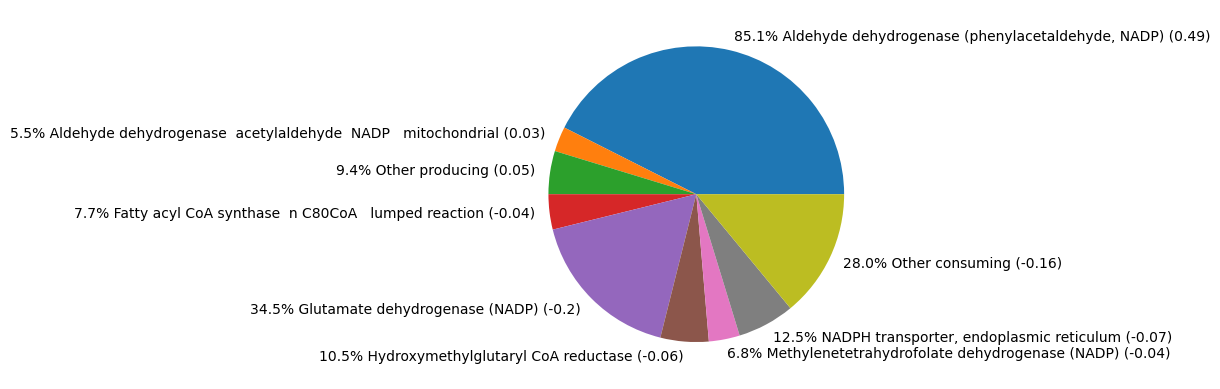

In [5]:
# Make a pie plot for napdh
threshold = 0.02 # threshold for including reaction in 'others' in pie chart
title = f'Rt_IFO0880_LEBp2023 NADPH producing and conusming fluxes (glucose uptake = {glucose_uptakes[0]})'
producing_nadph_fluxes_lowest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(nadph_fluxes_lowest_GR, title)
producing_nadph_fluxes_lowest_GR_pie_chart

fig.savefig("..\\..\\Thesis_paper_latex\\Pictures\\Rt_IFO0880_LEBp2023_biomass_max_NADPH.png")

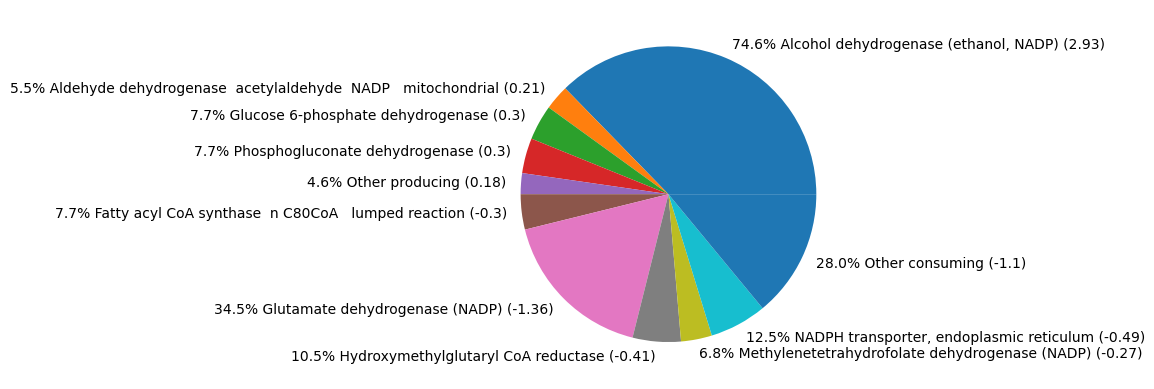

In [6]:
# Make a pie plot for napdh
threshold = 0.02 # threshold for including reaction in 'others' in pie chart
title = f'Rt_IFO0880_LEBp2023 NADPH producing and conusming fluxes (glucose uptake = {glucose_uptakes[4]})'
producing_nadph_fluxes_highest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(nadph_fluxes_highest_GR, title)
producing_nadph_fluxes_highest_GR_pie_chart

fig.savefig("..\\..\\Thesis_paper_latex\\Pictures\\Rt_IFO0880_LEBp2023_biomass_max_NADPH_max.png")

([<matplotlib.patches.Wedge at 0x1bbe6b35190>,
 [Text(1.0822462321782644, 0.1968326521082068, '11.5% 2-oxoglutarate dehydrogenase (0.28)'),
  Text(0.7623721893640335, 0.7929619441589177, '28.3% Glyceraldehyde-3-phosphate dehydrogenase (0.69)'),
  Text(0.1259222409665772, 1.0927687720785013, '13.1% Isocitrate dehydrogenase  NAD (0.32)'),
  Text(-0.47173119767648164, 0.9937150885131575, '22.4% Malate dehydrogenase  mitochondrial (0.55)'),
  Text(-0.8187347475043409, 0.7346246750749688, '2.8% Other producing (0.07)'),
  Text(-1.0357010565351985, 0.37057161452528126, '21.9% Pyruvate dehydrogenase (0.53)'),
  Text(-1.0464743614574792, -0.3389563553205066, '19.9% Aldehyde dehydrogenase (phenylacetaldehyde, NAD) (-0.49)'),
  Text(-0.8017311942866703, -0.7531448015539042, '8.1% malate dehydrogenase (-0.2)'),
  Text(0.443776986269636, -1.0065098044517198, '70.3% NADH dehydrogenase, mitochondrial (-1.72)'),
  Text(1.099638031840481, -0.028216997182431435, '1.6% Other consuming (-0.04)')])

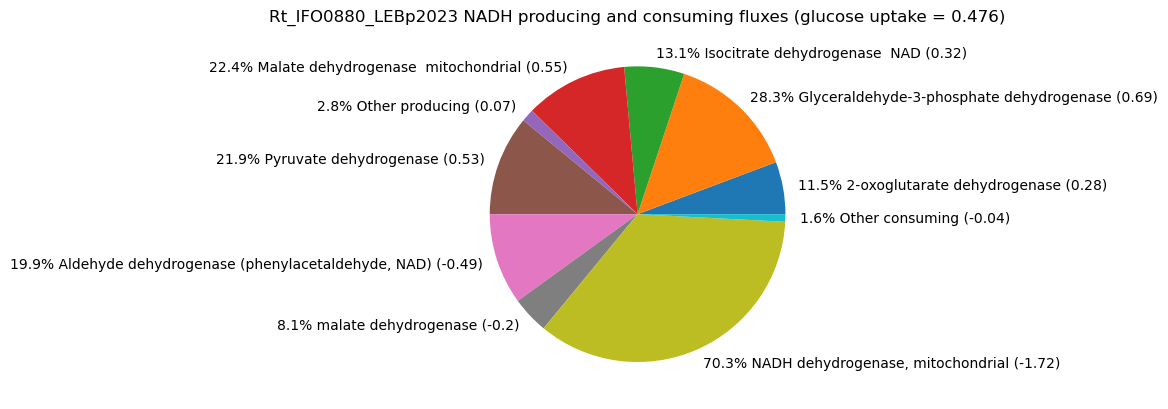

In [ ]:
# Make a pie plot for nadh 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'Rt_IFO0880_LEBp2023 NADH producing and consuming fluxes (glucose uptake = {glucose_uptakes[0]})'
producing_nadh_fluxes_lowest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(nadh_fluxes_lowest_GR, title, threshold)
producing_nadh_fluxes_lowest_GR_pie_chart

([<matplotlib.patches.Wedge at 0x1bbed72c890>,
 [Text(1.0857646129311325, 0.17639502630887444, '10.3% 2-oxoglutarate dehydrogenase (1.51)'),
  Text(0.7775314066101935, 0.7781034068392029, '29.5% Glyceraldehyde-3-phosphate dehydrogenase (4.35)'),
  Text(0.1435110154788385, 1.0905982708753177, '12.1% Isocitrate dehydrogenase  NAD (1.79)'),
  Text(-0.4457436722014168, 1.0056403823894484, '22.8% Malate dehydrogenase  mitochondrial (3.35)'),
  Text(-0.8080250143888804, 0.7463883547603417, '3.2% Other producing (0.47)'),
  Text(-1.0341598526109888, 0.374851169462786, '22.1% Pyruvate dehydrogenase (3.26)'),
  Text(-1.0465181435875273, -0.33882115509825494, '19.9% Alcohol dehydrogenase (ethanol) (-2.93)'),
  Text(-0.7882969428794054, -0.7671948447734666, '9.3% malate dehydrogenase (-1.36)'),
  Text(0.4580228774505614, -1.0001075160860997, '68.9% NADH dehydrogenase, mitochondrial (-10.15)'),
  Text(1.0995292375271901, -0.03217849938819531, '1.9% Other consuming (-0.27)')])

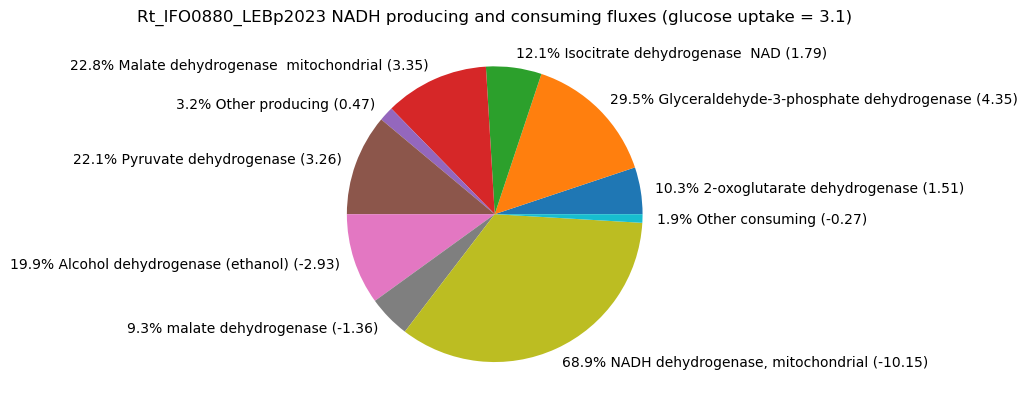

In [ ]:
# Make a pie plot for nadh 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'Rt_IFO0880_LEBp2023 NADH producing and consuming fluxes (glucose uptake = {glucose_uptakes[4]})'
producing_nadh_fluxes_highest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(nadh_fluxes_highest_GR, title, threshold)
producing_nadh_fluxes_highest_GR_pie_chart

([<matplotlib.patches.Wedge at 0x1bbe884de50>,
 [Text(0.3519273694144343, 1.0421838257510219, '79.3% ATP synthase  mitochondrial (6.31)'),
  Text(-0.8748433589226117, 0.6668201386798412, '0.0% Other producing (0.0)'),
  Text(-0.9574699045702043, 0.5415268985399749, '8.7% Phosphoglycerate kinase (0.69)'),
  Text(-1.0673559820075107, 0.26599099171359686, '8.5% Pyruvate kinase (0.68)'),
  Text(-1.0983295233522727, 0.06059915950547016, '3.5% Succinate  CoA ligase  ADP forming (0.28)'),
  Text(-1.0992888150681854, -0.03954871762756636, '2.3% ATP-Citrate lyase (-0.18)'),
  Text(-1.0927563312529744, -0.12603015713129753, '2.7% Adenylate kinase (-0.22)'),
  Text(-1.0138963862346846, -0.42663112636122513, '15.3% ATP maintenance requirement (-1.22)'),
  Text(0.003847657630875569, -1.0999932706752145, '59.6% Biomass (-4.74)'),
  Text(0.9446063646991649, -0.5636655176341981, '6.0% Hexokinase (D-glucose:ATP) (-0.48)'),
  Text(1.053950664277562, -0.314941260029368, '9.8% Other consuming (-0.78)'),
 

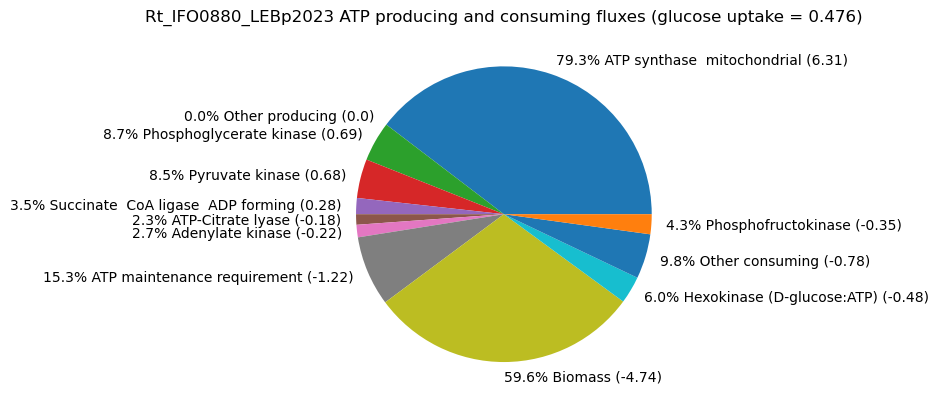

In [ ]:
# Make a pie plot for atp 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'Rt_IFO0880_LEBp2023 ATP producing and consuming fluxes (glucose uptake = {glucose_uptakes[0]})'
producing_atp_fluxes_lowest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(atp_fluxes_lowest_GR, title,  threshold)
producing_atp_fluxes_lowest_GR_pie_chart

([<matplotlib.patches.Wedge at 0x1bbeb8463f0>,
 [Text(0.3633953585062925, 1.0382407299928487, '78.6% ATP synthase  mitochondrial (37.07)'),
  Text(-0.8599341401004184, 0.6859397019343276, '0.0% Other producing (0.0)'),
  Text(-0.9498674023497118, 0.5547539255863008, '9.2% Phosphoglycerate kinase (4.35)'),
  Text(-1.067901116979157, 0.2637938671665223, '9.0% Pyruvate kinase (4.26)'),
  Text(-1.0986138344384004, 0.05520545969879238, '3.2% Succinate  CoA ligase  ADP forming (1.51)'),
  Text(-1.0990419701516008, -0.04589932292842742, '2.7% ATP-Citrate lyase (-1.25)'),
  Text(-1.0902455194360414, -0.14616671081212917, '3.2% Adenylate kinase (-1.5)'),
  Text(-1.0725954464773202, -0.2440061642584436, '2.6% ATP maintenance requirement (-1.22)'),
  Text(-0.2408840558635746, -1.0733009231481703, '69.1% Biomass (-32.61)'),
  Text(0.9062230264969614, -0.6235060755491382, '6.6% Hexokinase (D-glucose:ATP) (-3.1)'),
  Text(1.043824326835423, -0.347031374239529, '11.4% Other consuming (-5.36)'),
  Tex

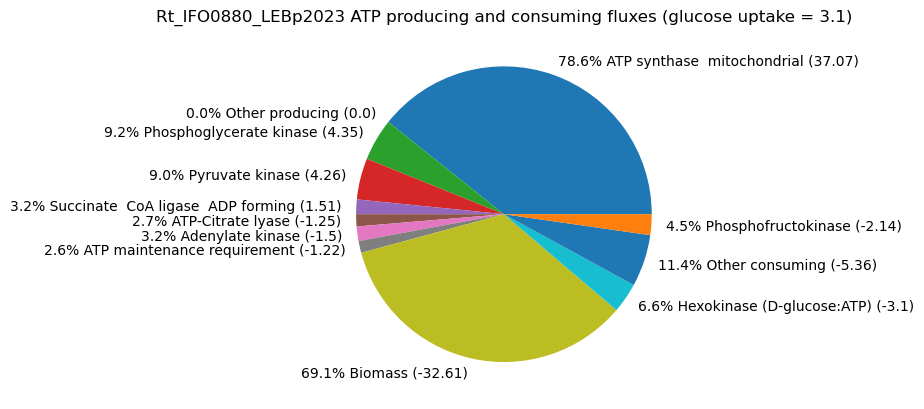

In [ ]:
# Make a pie plot for atp 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'Rt_IFO0880_LEBp2023 ATP producing and consuming fluxes (glucose uptake = {glucose_uptakes[4]})'
producing_atp_fluxes_highest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(atp_fluxes_highest_GR, title,  threshold)
producing_atp_fluxes_highest_GR_pie_chart

In [ ]:
# # Get all fluxes to excel
# with pd.ExcelWriter('C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Results\\Rt_IFO0880_jsb_results\\Rt_IFO0880_jsb_all_fluxes_biomass_max.xlsx') as excel_writer:
#     all_fluxes_biomass_max.to_excel(excel_writer, sheet_name='Sheet1', index=True)

In [ ]:
# #  Get all flux values separately for dif growth rates, make them to a csv file
# for i in range(len(glucose_uptakes)):
#     all_fluxes_dif_glucose_uptakes.loc[i].to_csv(f'C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Results\\Rt_IFO0880_jsb_results\\fluxes_biomass_max_{growth_rates[i]}.csv', index=True)